In [27]:
import joblib
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd

In [28]:
df = pd.read_csv('../Dataset/FeatureEngineering_T2M_data.csv')

In [29]:
H = 7

t2m_targets = [f"t2m_d{h}_forecast" for h in range(1, H+1)]
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in num_cols if c not in t2m_targets]

In [30]:
X = df[feature_cols]         # shape = (n_samples, n_features)
Y = df[t2m_targets]           # shape = (n_samples, 7)

In [31]:
test_ratio = 0.1
n_samples = len(df)
split_idx = int(n_samples * (1 - test_ratio))

# split
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
Y_train, Y_test = Y.iloc[:split_idx], Y.iloc[split_idx:]

print("Train size:", X_train.shape, Y_train.shape)
print("Test  size:", X_test.shape, Y_test.shape)

Train size: (14732, 391) (14732, 7)
Test  size: (1637, 391) (1637, 7)


In [32]:
from lightgbm import LGBMRegressor

t2m_last_col = Y_train.columns[-1]

fs_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=63,
    random_state=42,
    n_jobs=-1
)

fs_model.fit(X_train, Y_train[t2m_last_col])

importances = pd.Series(fs_model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

TOP_K = 200  
selected_features = importances.head(TOP_K).index.tolist()

print(f"Selected top {TOP_K} features from LightGBM importance:")
print(selected_features)

X_train_fs = X_train[selected_features].copy()
X_test_fs  = X_test[selected_features].copy()

Selected top 200 features from LightGBM importance:
['month_progress', 'gwettop_roll7_std', 'dayofyear', 'doy_sin', 'tsoil4_roll7_std', 't2m_trend_strength', 'tsoil3_roll7_std', 'ts_max_roll7_std', 'rhoa_roll3_std', 'to3_lag7', 'to3', 'tsoil4_lag7', 'ts_min_roll7_std', 'gwettop_roll3_std', 'doy_cos', 't2mwet_roll7_std', 'v2m_roll7_std', 'tsoil4_roll3_std', 'rhoa_roll7_std', 'gwetprof_roll7_std', 'to3_lag3', 't2m_max_roll7_std', 'tsoil4', 't10m_min_roll7_std', 't10m_max_roll7_std', 't2m_min_roll7_std', 'tsoil3_lag7', 'to3_lag1', 'v50m_roll7_std', 'gwetroot_roll7_std', 'to3_lag6', 'gwetprof_roll3_std', 'to3_lag2', 'ts_min_roll3_std', 'to3_lag4', 'temp_gradient_surface', 'temp_gradient_altitude', 't2m_anomaly', 't2m_rolling_iqr', 'gwetroot_roll3_std', 't10m_roll7_std', 'tsoil3_roll3_std', 'tsoil3', 'to3_lag5', 'tsoil2_roll7_std', 't2m_anomaly_lag2', 't2m_volatility_3d_lag2', 'temp_gradient_surface_lag3', 'soil_temp_moisture', 't2m_anomaly_lag3', 'ts_max_roll7_mean', 'ts_max_roll3_std', 'v

In [33]:
rf_model = joblib.load('../Model/Weight/RandomForest_Multi_T2M_Model.joblib')
lgbm_model = joblib.load('../Model/Weight/LightGBM_Multi_T2M_Model.joblib')
xgb_model = joblib.load('../Model/Weight/Xgboost_Multi_T2M_Model.joblib')
lstm_model = load_model('../Model/Weight/LSTM_T2M_lookback7_Model.h5', compile=False)

In [34]:
# Example: Predict using all models and average (for regression)
def ensemble_predict(X):
    preds_rf = rf_model.predict(X)
    preds_lgbm = lgbm_model.predict(X)
    preds_xgb = xgb_model.predict(X)
        
    # Average predictions
    return np.mean([preds_rf, preds_lgbm, preds_xgb], axis=0)

In [35]:
y_pred_ensemble = ensemble_predict(X_test_fs)

### Metric

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from math import sqrt

In [37]:
for h in range(H):
    rmse_h = sqrt(mean_squared_error(Y_test.iloc[:, h], y_pred_ensemble[:, h]))
    print(f"Day +{h+1}: RMSE = {rmse_h:.3f}")

# RMSE for horizon
rmse_all = sqrt(mean_squared_error(Y_test, y_pred_ensemble))
print(f"Overall RMSE: {rmse_all:.3f}\n")

# MAE (Mean Absolute Error)
for h in range(H):
    mae_h = mean_absolute_error(Y_test.iloc[:, h], y_pred_ensemble[:, h])
    print(f"Day +{h+1}: MAE = {mae_h:.3f}")

mae_all = mean_absolute_error(Y_test, y_pred_ensemble)
print(f"Overall MAE: {mae_all:.3f}\n")

# R² Score (Coefficient of Determination)
r2_scores = []
for h in range(H):
    r2_h = r2_score(Y_test.iloc[:, h], y_pred_ensemble[:, h])
    r2_scores.append(r2_h)
    print(f"Day +{h+1}: R² = {r2_h:.3f} ({r2_h*100:.1f}%)")

r2_all = r2_score(Y_test, y_pred_ensemble)
print(f"Overall R² Score: {r2_all:.3f} ({r2_all*100:.1f}%)\n")

# MAPE (Mean Absolute Percentage Error)
mape_scores = []
for h in range(H):
    actual = Y_test.iloc[:, h]
    predicted = y_pred_ensemble[:, h]
    mape_h = np.mean(np.abs((actual - predicted) / actual)) * 100
    mape_scores.append(mape_h)
    print(f"Day +{h+1}: MAPE = {mape_h:.2f}%")

# Overall MAPE
mape_all = np.mean(np.abs((Y_test.values - y_pred_ensemble) / Y_test.values)) * 100
print(f"Overall MAPE: {mape_all:.2f}%")

Day +1: RMSE = 0.679
Day +2: RMSE = 0.924
Day +3: RMSE = 1.020
Day +4: RMSE = 1.056
Day +5: RMSE = 1.076
Day +6: RMSE = 1.101
Day +7: RMSE = 1.124
Overall RMSE: 1.007

Day +1: MAE = 0.506
Day +2: MAE = 0.691
Day +3: MAE = 0.770
Day +4: MAE = 0.797
Day +5: MAE = 0.813
Day +6: MAE = 0.827
Day +7: MAE = 0.843
Overall MAE: 0.750

Day +1: R² = 0.867 (86.7%)
Day +2: R² = 0.753 (75.3%)
Day +3: R² = 0.701 (70.1%)
Day +4: R² = 0.679 (67.9%)
Day +5: R² = 0.670 (67.0%)
Day +6: R² = 0.658 (65.8%)
Day +7: R² = 0.647 (64.7%)
Overall R² Score: 0.711 (71.1%)

Day +1: MAPE = 1.81%
Day +2: MAPE = 2.49%
Day +3: MAPE = 2.77%
Day +4: MAPE = 2.87%
Day +5: MAPE = 2.93%
Day +6: MAPE = 2.98%
Day +7: MAPE = 3.04%
Overall MAPE: 2.70%


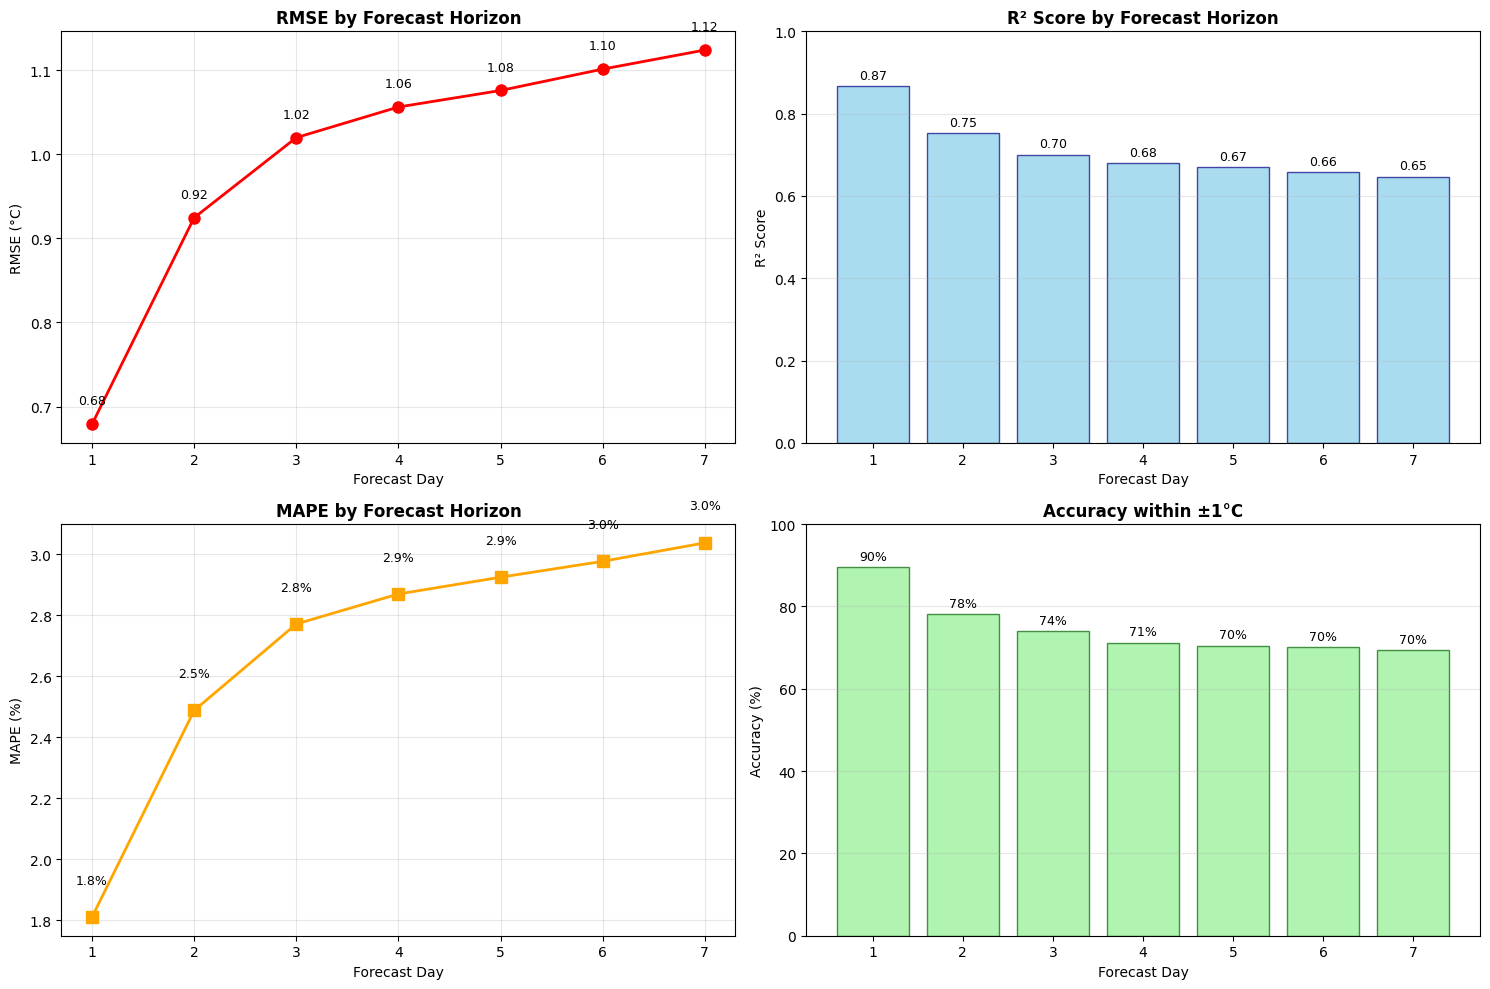

In [38]:
# Visual Performance Analysis
import matplotlib.pyplot as plt

# Create comprehensive performance visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. RMSE by forecast horizon
days = list(range(1, H+1))
rmse_by_day = [sqrt(mean_squared_error(Y_test.iloc[:, h], y_pred_ensemble[:, h])) for h in range(H)]

axes[0, 0].plot(days, rmse_by_day, marker='o', linewidth=2, markersize=8, color='red')
axes[0, 0].set_title('RMSE by Forecast Horizon', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Forecast Day')
axes[0, 0].set_ylabel('RMSE (°C)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(days)

# 2. R² Score by forecast horizon
axes[0, 1].bar(days, r2_scores, color='skyblue', alpha=0.7, edgecolor='navy')
axes[0, 1].set_title('R² Score by Forecast Horizon', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Forecast Day')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_xticks(days)
axes[0, 1].set_ylim(0, 1)

# 3. MAPE by forecast horizon
axes[1, 0].plot(days, mape_scores, marker='s', linewidth=2, markersize=8, color='orange')
axes[1, 0].set_title('MAPE by Forecast Horizon', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Forecast Day')
axes[1, 0].set_ylabel('MAPE (%)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(days)

# 4. Accuracy within 1°C tolerance
accuracy_1c = []
for h in range(H):
    actual = Y_test.iloc[:, h]
    predicted = y_pred_ensemble[:, h]
    within_tolerance = np.abs(actual - predicted) <= 1.0
    accuracy = (within_tolerance.sum() / len(actual)) * 100
    accuracy_1c.append(accuracy)

axes[1, 1].bar(days, accuracy_1c, color='lightgreen', alpha=0.7, edgecolor='darkgreen')
axes[1, 1].set_title('Accuracy within ±1°C', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Forecast Day')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_xticks(days)
axes[1, 1].set_ylim(0, 100)

# Add performance values as text on bars/points
for i, (day, rmse) in enumerate(zip(days, rmse_by_day)):
    axes[0, 0].text(day, rmse + 0.02, f'{rmse:.2f}', ha='center', va='bottom', fontsize=9)

for i, (day, r2) in enumerate(zip(days, r2_scores)):
    axes[0, 1].text(day, r2 + 0.01, f'{r2:.2f}', ha='center', va='bottom', fontsize=9)

for i, (day, mape) in enumerate(zip(days, mape_scores)):
    axes[1, 0].text(day, mape + 0.1, f'{mape:.1f}%', ha='center', va='bottom', fontsize=9)

for i, (day, acc) in enumerate(zip(days, accuracy_1c)):
    axes[1, 1].text(day, acc + 1, f'{acc:.0f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

H = 7

rmse_list = []
mae_list = []
mape_list = []
r2_list = []

for h in range(H):
    y_true_h = Y_test.iloc[:, h]
    y_pred_h = y_pred_ensemble[:, h]

    rmse_list.append(np.sqrt(mean_squared_error(y_true_h, y_pred_h)))
    mae_list.append(mean_absolute_error(y_true_h, y_pred_h))
    mape_list.append(mape(y_true_h, y_pred_h))
    r2_list.append(r2_score(y_true_h, y_pred_h))

# ---- Horizontal Display ----
print("==== RMSE ====")
print(" | ".join([f"Day +{i+1}: {rmse_list[i]:.3f}" for i in range(H)]))

print("\n==== MAE ====")
print(" | ".join([f"Day +{i+1}: {mae_list[i]:.3f}" for i in range(H)]))

print("\n==== MAPE (%) ====")
print(" | ".join([f"Day +{i+1}: {mape_list[i]:.2f}%" for i in range(H)]))

print("\n==== R² ====")
print(" | ".join([f"Day +{i+1}: {r2_list[i]:.3f}" for i in range(H)]))

# ---- Accuracy (%) from R² ----
print("\n==== Accuracy (%) from R² ====")
print(" | ".join([f"Day +{i+1}: {r2_list[i]*100:.1f}%" for i in range(H)]))

# ---- Overall metrics ----
rmse_overall = np.sqrt(mean_squared_error(Y_test, y_pred_ensemble))
mae_overall = mean_absolute_error(Y_test, y_pred_ensemble)
mape_overall = mape(Y_test, y_pred_ensemble)
r2_overall = r2_score(Y_test, y_pred_ensemble)

print("\n==== Overall ====")
print(f"RMSE={rmse_overall:.3f} | MAE={mae_overall:.3f} | "
      f"MAPE={mape_overall:.2f}% | R²={r2_overall:.3f} | "
      f"Accuracy={(r2_overall*100):.1f}%")

==== RMSE ====
Day +1: 0.679 | Day +2: 0.924 | Day +3: 1.020 | Day +4: 1.056 | Day +5: 1.076 | Day +6: 1.101 | Day +7: 1.124

==== MAE ====
Day +1: 0.506 | Day +2: 0.691 | Day +3: 0.770 | Day +4: 0.797 | Day +5: 0.813 | Day +6: 0.827 | Day +7: 0.843

==== MAPE (%) ====
Day +1: 1.81% | Day +2: 2.49% | Day +3: 2.77% | Day +4: 2.87% | Day +5: 2.93% | Day +6: 2.98% | Day +7: 3.04%

==== R² ====
Day +1: 0.867 | Day +2: 0.753 | Day +3: 0.701 | Day +4: 0.679 | Day +5: 0.670 | Day +6: 0.658 | Day +7: 0.647

==== Accuracy (%) from R² ====
Day +1: 86.7% | Day +2: 75.3% | Day +3: 70.1% | Day +4: 67.9% | Day +5: 67.0% | Day +6: 65.8% | Day +7: 64.7%

==== Overall ====
RMSE=1.007 | MAE=0.750 | MAPE=2.70% | R²=0.711 | Accuracy=71.1%


### Predict 7 days

In [40]:
X_last = df[selected_features].iloc[[-1]] # shape = (1, n_features)
t2m_next7 = ensemble_predict(X_last)[0]

# Get the last date in dataset and generate next 7 days
last_date = pd.to_datetime(df["date"].iloc[-1])
print(f"Last data date: {last_date.strftime('%Y-%m-%d (%A)')}")
print(f"Starting forecast from: {(last_date + pd.Timedelta(days=1)).strftime('%Y-%m-%d (%A)')}")
print()

# Generate forecast with dates
forecast_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 8)]

for i, (date, temp) in enumerate(zip(forecast_dates, t2m_next7), start=1):
    day_name = date.strftime('%A')
    date_str = date.strftime('%Y-%m-%d')
    print(f"Day +{i}: {date_str} ({day_name}) → {temp:.2f}°C")

print(f"\nForecast Range: {t2m_next7.min():.2f}°C to {t2m_next7.max():.2f}°C")
print(f"Average Temperature: {t2m_next7.mean():.2f}°C")

# Temperature trend analysis
temp_trend = "increasing" if t2m_next7[-1] > t2m_next7[0] else "decreasing"
temp_change = abs(t2m_next7[-1] - t2m_next7[0])
print(f"7-day Trend: {temp_trend} ({temp_change:.2f}°C change)")

Last data date: 2025-11-14 (Friday)
Starting forecast from: 2025-11-15 (Saturday)

Day +1: 2025-11-15 (Saturday) → 25.51°C
Day +2: 2025-11-16 (Sunday) → 25.51°C
Day +3: 2025-11-17 (Monday) → 25.56°C
Day +4: 2025-11-18 (Tuesday) → 25.46°C
Day +5: 2025-11-19 (Wednesday) → 25.30°C
Day +6: 2025-11-20 (Thursday) → 25.41°C
Day +7: 2025-11-21 (Friday) → 25.43°C

Forecast Range: 25.30°C to 25.56°C
Average Temperature: 25.45°C
7-day Trend: decreasing (0.08°C change)


### Pattern plot

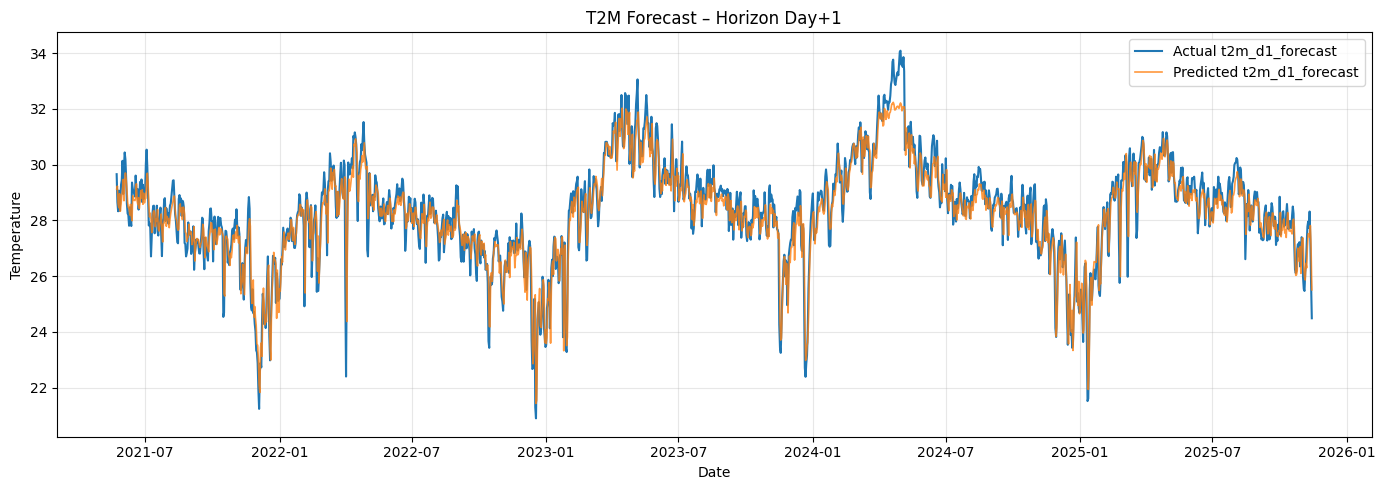

In [41]:
import matplotlib.pyplot as plt

dates_test = pd.to_datetime(df["date"].iloc[split_idx:])

h = 0   # 0 = day+1, 6 = day+7
target_name = t2m_targets[h]

plt.figure(figsize=(14, 5))
plt.plot(dates_test, Y_test.iloc[:, h], label=f"Actual {target_name}", linewidth=1.5)
plt.plot(dates_test, y_pred_ensemble[:, h], label=f"Predicted {target_name}", linewidth=1.2, alpha=0.8)

plt.title(f"T2M Forecast – Horizon Day+{h+1}")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

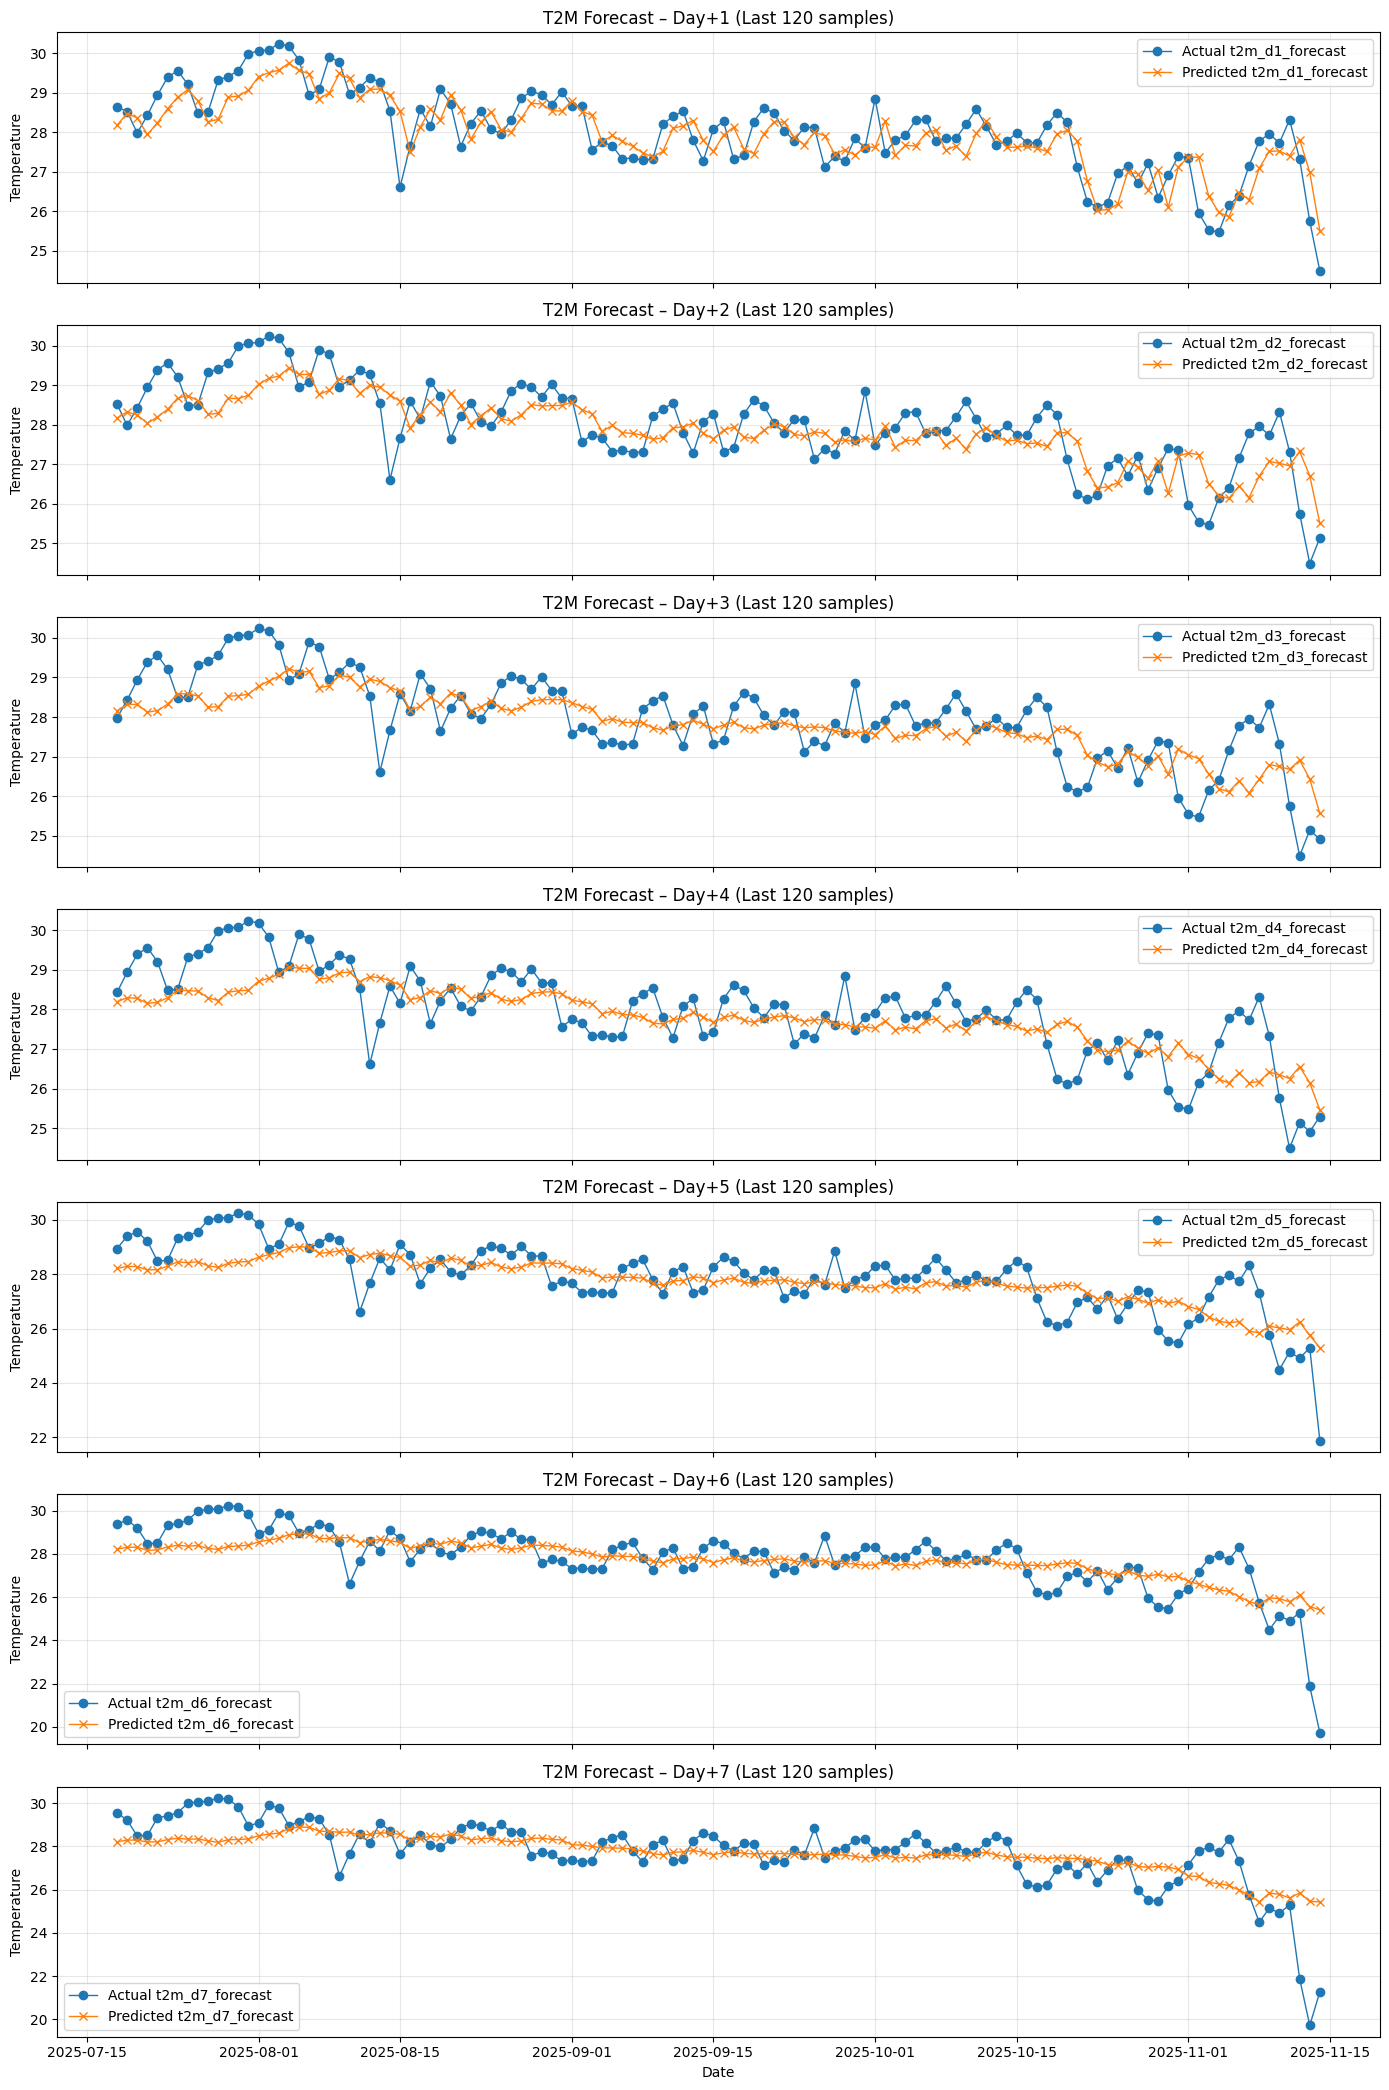

In [42]:
N = 120  # last 4 months
days = [f"Day+{i+1}" for i in range(H)]
fig, axs = plt.subplots(H, 1, figsize=(14, 3*H), sharex=True)
for h in range(H):
    dates_zoom = dates_test[-N:]
    y_test_zoom = Y_test.iloc[-N:, h]
    y_pred_zoom = y_pred_ensemble[-N:, h]
    axs[h].plot(dates_zoom, y_test_zoom, label=f"Actual {t2m_targets[h]}", marker="o", linewidth=1)
    axs[h].plot(dates_zoom, y_pred_zoom, label=f"Predicted {t2m_targets[h]}", marker="x", linewidth=1)
    axs[h].set_title(f"T2M Forecast – {days[h]} (Last {N} samples)")
    axs[h].set_ylabel("Temperature")
    axs[h].legend()
    axs[h].grid(True, alpha=0.3)
plt.xlabel("Date")
plt.tight_layout()
plt.show()

### Compare Model

#### Load LSTM

In [43]:
from sklearn.preprocessing import MinMaxScaler
import joblib
lstm_feature_cols = [
    "tsoil1", "tsoil2", "tsoil3", "tsoil4",
    "t2m", "t2m_max", "t2m_min",
    "t10m", "t10m_max", "t10m_min",
    "ts", "ts_min", "ts_max", "tsurf",
    "t2m_range", "t10m_range", "ts_range",
    "v2m", "v10m", "v50m",
    "rhoa", "t2mwet",
    "gwettop", "gwetroot", "gwetprof",
    "evptrns", "et_total", "evland",
    "z0m", "to3",
    ]
lstm_targets = [f"t2m_d{h}_forecast" for h in range(1, H+1)]
lstm_df = df[lstm_feature_cols + lstm_targets].dropna().reset_index(drop=True)
lstm_scaler_X = joblib.load("../Model/Weight/LSTM_T2M_lookback7_Scaler_X.joblib")
lstm_scaler_y = joblib.load("../Model/Weight/LSTM_T2M_lookback7_Scaler_y.joblib")

lstm_scaled_X = lstm_scaler_X.transform(lstm_df[lstm_feature_cols])
lstm_scaled_y = lstm_scaler_y.transform(lstm_df[lstm_targets])

lstm_lookback = 7
def create_lstm_sequences(X, y, lookback):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback - H):
        X_seq.append(X[i:i+lookback])
        y_seq.append(y[i+lookback])
    return np.array(X_seq), np.array(y_seq)
lstm_X_seq, lstm_Y_seq = create_lstm_sequences(lstm_scaled_X, lstm_scaled_y, lstm_lookback)
n_samples = len(lstm_df)
test_ratio = 0.1
split_idx = int(n_samples * (1 - test_ratio))
lstm_X_train, lstm_X_test = lstm_X_seq[:split_idx-lstm_lookback-H], lstm_X_seq[split_idx-lstm_lookback-H:]
lstm_Y_train, lstm_Y_test = lstm_Y_seq[:split_idx-lstm_lookback-H], lstm_Y_seq[split_idx-lstm_lookback-H:]
lstm_Y_pred = lstm_model.predict(lstm_X_test)
lstm_Y_test_inv = lstm_scaler_y.inverse_transform(lstm_Y_test)
lstm_Y_pred_inv = lstm_scaler_y.inverse_transform(lstm_Y_pred)

52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step


In [44]:
print("LSTM Y_test_inv shape:", lstm_Y_test_inv.shape)
print("LSTM Y_pred_inv shape:", lstm_Y_pred_inv.shape)

LSTM Y_test_inv shape: (1637, 7)
LSTM Y_pred_inv shape: (1637, 7)


In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

H = 7

rmse_list = []
mae_list = []
mape_list = []
r2_list = []

for h in range(H):
    y_true_h = lstm_Y_test[:, h]
    y_pred_h = lstm_Y_pred[:, h]

    rmse_list.append(np.sqrt(mean_squared_error(y_true_h, y_pred_h)))
    mae_list.append(mean_absolute_error(y_true_h, y_pred_h))
    mape_list.append(mape(y_true_h, y_pred_h))
    r2_list.append(r2_score(y_true_h, y_pred_h))

# ---- Horizontal Display ----
print("==== RMSE ====")
print(" | ".join([f"Day +{i+1}: {rmse_list[i]:.3f}" for i in range(H)]))

print("\n==== MAE ====")
print(" | ".join([f"Day +{i+1}: {mae_list[i]:.3f}" for i in range(H)]))

print("\n==== MAPE (%) ====")
print(" | ".join([f"Day +{i+1}: {mape_list[i]:.2f}%" for i in range(H)]))

print("\n==== R² ====")
print(" | ".join([f"Day +{i+1}: {r2_list[i]:.3f}" for i in range(H)]))

# ---- Accuracy (%) from R² ----
print("\n==== Accuracy (%) from R² ====")
print(" | ".join([f"Day +{i+1}: {r2_list[i]*100:.1f}%" for i in range(H)]))

# ---- Overall metrics ----
rmse_overall = np.sqrt(mean_squared_error(lstm_Y_test_inv, lstm_Y_pred_inv))
mae_overall = mean_absolute_error(lstm_Y_test_inv, lstm_Y_pred_inv)
mape_overall = mape(lstm_Y_test_inv, lstm_Y_pred_inv)
r2_overall = r2_score(lstm_Y_test_inv, lstm_Y_pred_inv)

print("\n==== Overall ====")
print(f"RMSE={rmse_overall:.3f} | MAE={mae_overall:.3f} | "
      f"MAPE={mape_overall:.2f}% | R²={r2_overall:.3f} | "
      f"Accuracy={(r2_overall*100):.1f}%")

==== RMSE ====
Day +1: 0.052 | Day +2: 0.057 | Day +3: 0.059 | Day +4: 0.060 | Day +5: 0.060 | Day +6: 0.062 | Day +7: 0.062

==== MAE ====
Day +1: 0.038 | Day +2: 0.042 | Day +3: 0.043 | Day +4: 0.044 | Day +5: 0.045 | Day +6: 0.046 | Day +7: 0.047

==== MAPE (%) ====
Day +1: 6.22% | Day +2: 6.87% | Day +3: 7.12% | Day +4: 7.21% | Day +5: 7.30% | Day +6: 7.44% | Day +7: 7.58%

==== R² ====
Day +1: 0.748 | Day +2: 0.701 | Day +3: 0.681 | Day +4: 0.672 | Day +5: 0.663 | Day +6: 0.650 | Day +7: 0.644

==== Accuracy (%) from R² ====
Day +1: 74.8% | Day +2: 70.1% | Day +3: 68.1% | Day +4: 67.2% | Day +5: 66.3% | Day +6: 65.0% | Day +7: 64.4%

==== Overall ====
RMSE=1.050 | MAE=0.775 | MAPE=2.80% | R²=0.680 | Accuracy=68.0%


#### Compare with day

In [46]:
def ensemble_avg(X):
    preds_rf = rf_model.predict(X)
    preds_lgbm = lgbm_model.predict(X)
    preds_xgb = xgb_model.predict(X)
    return np.mean([preds_rf, preds_lgbm, preds_xgb], axis=0)

models = {
    "Random Forest": rf_model,
    "LightGBM": lgbm_model,
    "XGBoost": xgb_model,
    "LSTM": lstm_model,
    "Ensemble": ensemble_avg
}

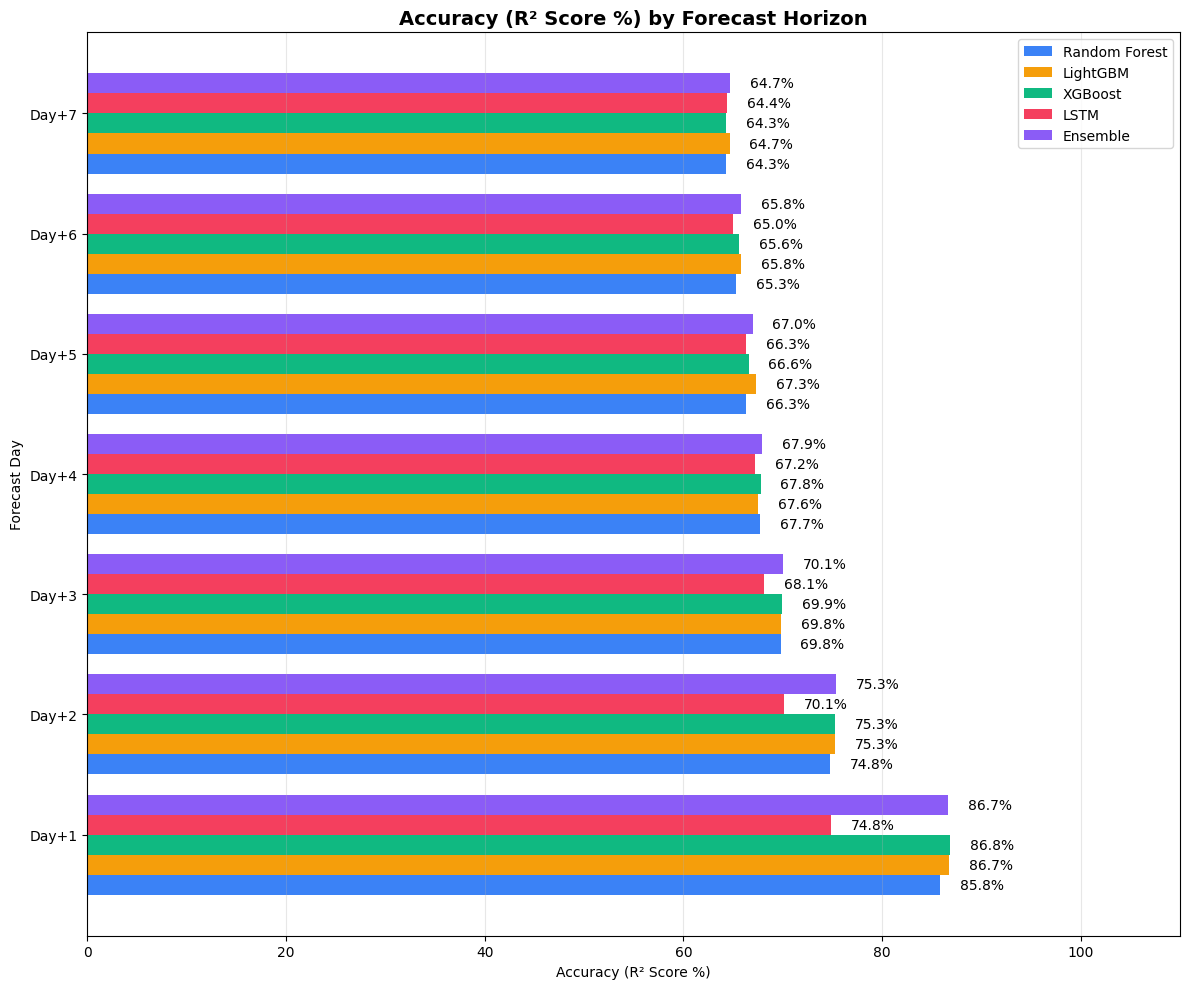

In [47]:
fig, ax = plt.subplots(figsize=(12, 10))
days = np.arange(1, H+1)
bar_height = 0.24
y = np.arange(H)[::-1]  # reverse y so Day 1 is at the top

model_colors = {
    "Random Forest": "#3B82F6",
    "LightGBM": "#F59E0B",
    "XGBoost": "#10B981",
    "LSTM": "#F43F5E",
    "Ensemble": "#8B5CF6"
}

num_models = len(models)
gap = bar_height * (num_models + 1)  # increase gap between Day groups
for i, (name, model) in enumerate(models.items()):
    if name == "Ensemble":
        y_pred = model(X_test_fs)
        r2_scores = [r2_score(Y_test.iloc[:, h], y_pred[:, h]) for h in range(H)]
    elif name == "LSTM":
        r2_scores = [r2_score(lstm_Y_test_inv[:, h], lstm_Y_pred_inv[:, h]) for h in range(H)]
    else:
        y_pred = model.predict(X_test_fs)
        r2_scores = [r2_score(Y_test.iloc[:, h], y_pred[:, h]) for h in range(H)]
    r2_scores = r2_scores[::-1]  # reverse so Day 1 is at the top
    color = model_colors.get(name, None)
    bars = ax.barh(y * gap + i * bar_height, np.array(r2_scores)*100, height=bar_height, label=name, color=color)
    for j, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width + 2, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', ha='left', va='center', fontsize=10)
        
ax.set_title('Accuracy (R² Score %) by Forecast Horizon', fontsize=14, fontweight='bold')
ax.set_ylabel('Forecast Day')
ax.set_xlabel('Accuracy (R² Score %)')
ax.set_yticks(y * gap + (num_models/2) * bar_height)
ax.set_yticklabels([f'Day+{d}' for d in days[::-1]])
ax.set_xlim(0, 110)
ax.grid(True, alpha=0.3, axis='x')
ax.legend()
plt.tight_layout()
plt.show()

#### Compare overall

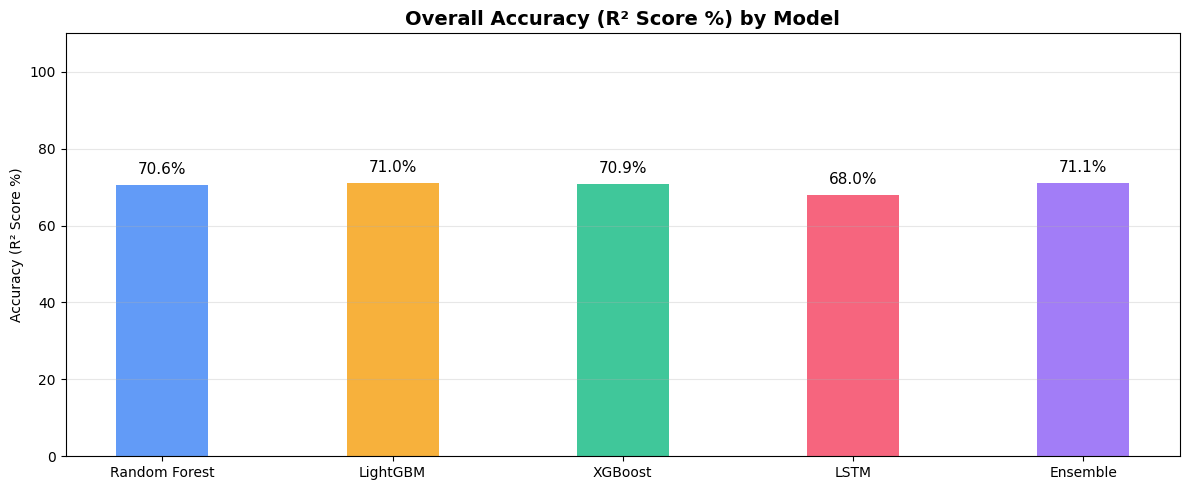

In [48]:
# Compare overall R² Score (%) for all models
overall_r2 = {}
for name, model in models.items():
    if name == "Ensemble":
        y_pred = model(X_test_fs)
        r2 = r2_score(Y_test, y_pred)
    elif name == "LSTM":
        r2 = r2_score(lstm_Y_test_inv, lstm_Y_pred_inv)
    else:
        y_pred = model.predict(X_test_fs)
        r2 = r2_score(Y_test, y_pred)
    overall_r2[name] = r2 * 100

# Plot overall comparison (vertical bar chart, thicker bars)
fig, ax = plt.subplots(figsize=(12, 5))
model_names = list(overall_r2.keys())
r2_values = list(overall_r2.values())
colors = [model_colors.get(name, "gray") for name in model_names]
bar_width = 0.4
bars = ax.bar(model_names, r2_values, color=colors, alpha=0.8, width=bar_width)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 2, f'{height:.1f}%', ha='center', va='bottom', fontsize=11)

ax.set_title('Overall Accuracy (R² Score %) by Model', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy (R² Score %)')
ax.set_ylim(0, 110)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### Pattern plot

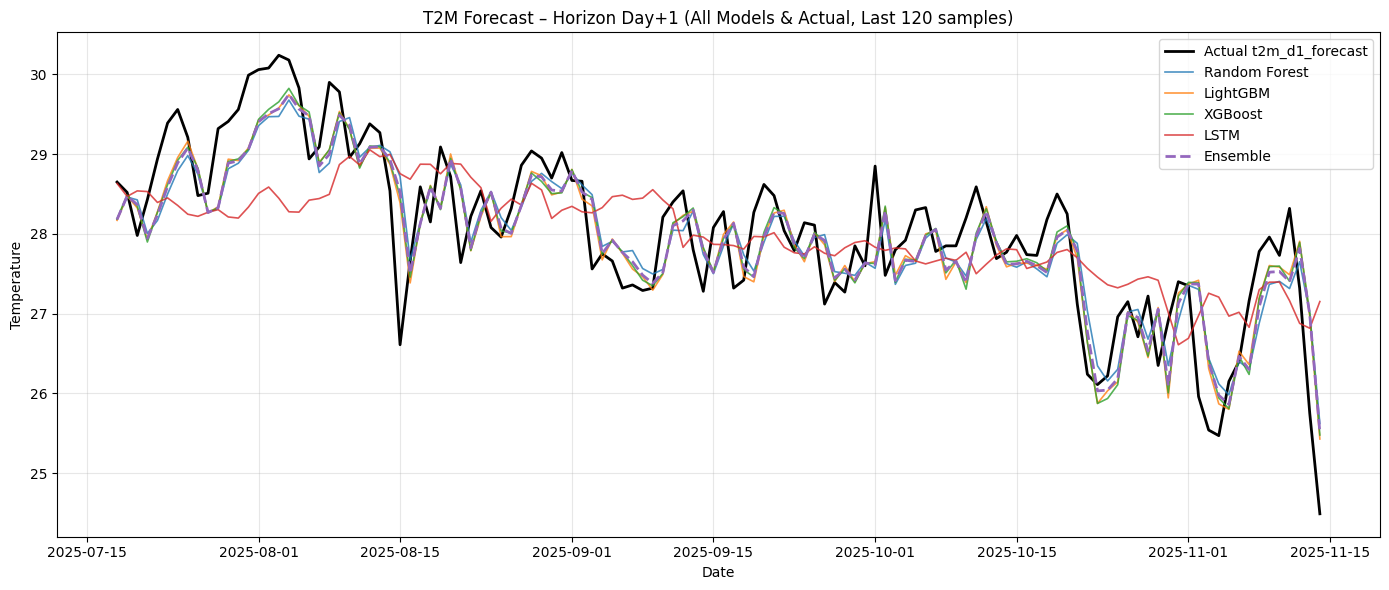

In [62]:
import matplotlib.pyplot as plt
N = 120  #  4 Monyths last
h = 0   # 0 = day+1, 6 = day+7
target_name = t2m_targets[h]
dates_test = pd.to_datetime(df["date"].iloc[split_idx:])
dates_zoom = dates_test[-N:]
plt.figure(figsize=(14, 6))

# Actual values
plt.plot(dates_zoom, Y_test.iloc[-N:, h], label=f"Actual {target_name}", linewidth=2, color="black")

# Random Forest
y_pred_rf = rf_model.predict(X_test_fs)
plt.plot(dates_zoom, y_pred_rf[-N:, h], label="Random Forest", linewidth=1.2, alpha=0.8)

# LightGBM
y_pred_lgbm = lgbm_model.predict(X_test_fs)
plt.plot(dates_zoom, y_pred_lgbm[-N:, h], label="LightGBM", linewidth=1.2, alpha=0.8)

# XGBoost
y_pred_xgb = xgb_model.predict(X_test_fs)
plt.plot(dates_zoom, y_pred_xgb[-N:, h], label="XGBoost", linewidth=1.2, alpha=0.8)

# LSTM
plt.plot(dates_zoom, lstm_Y_pred_inv[-N:, h], label="LSTM", linewidth=1.2, alpha=0.8)

# Ensemble
plt.plot(dates_zoom, y_pred_ensemble[-N:, h], label="Ensemble", linewidth=2, linestyle="--")

plt.title(f"T2M Forecast – Horizon Day+{h+1} (All Models & Actual, Last {N} samples)")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

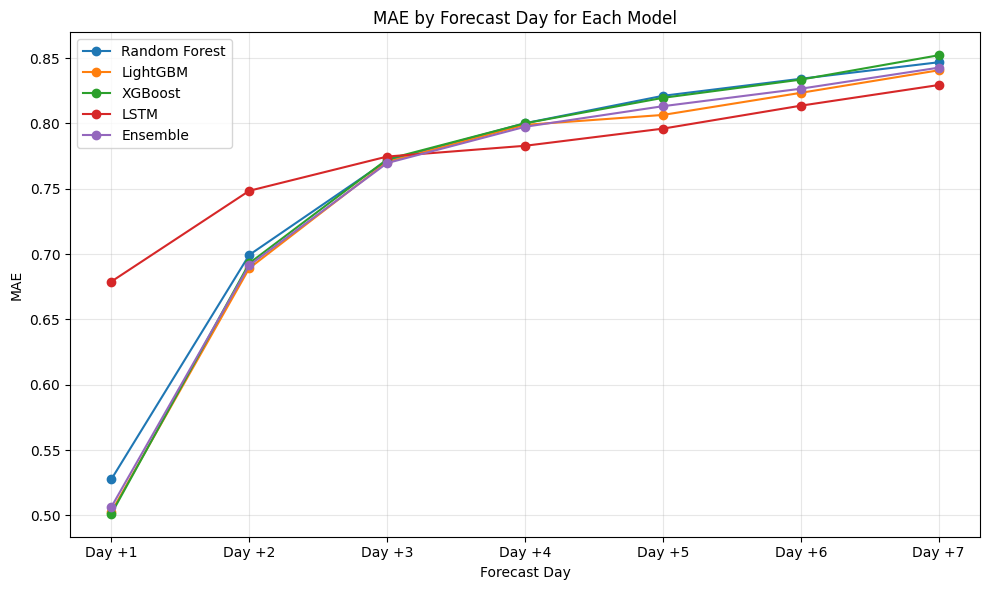

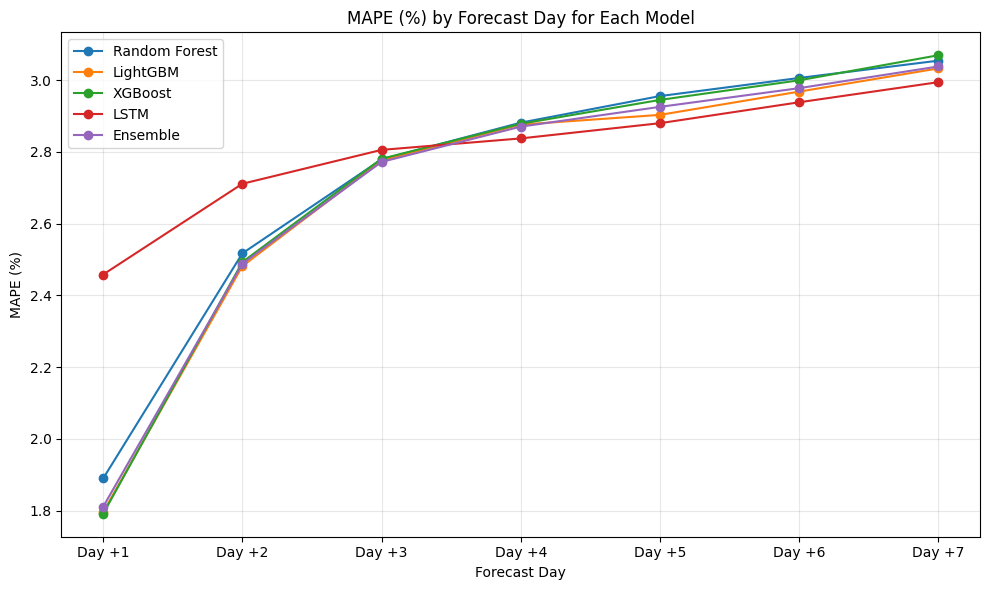

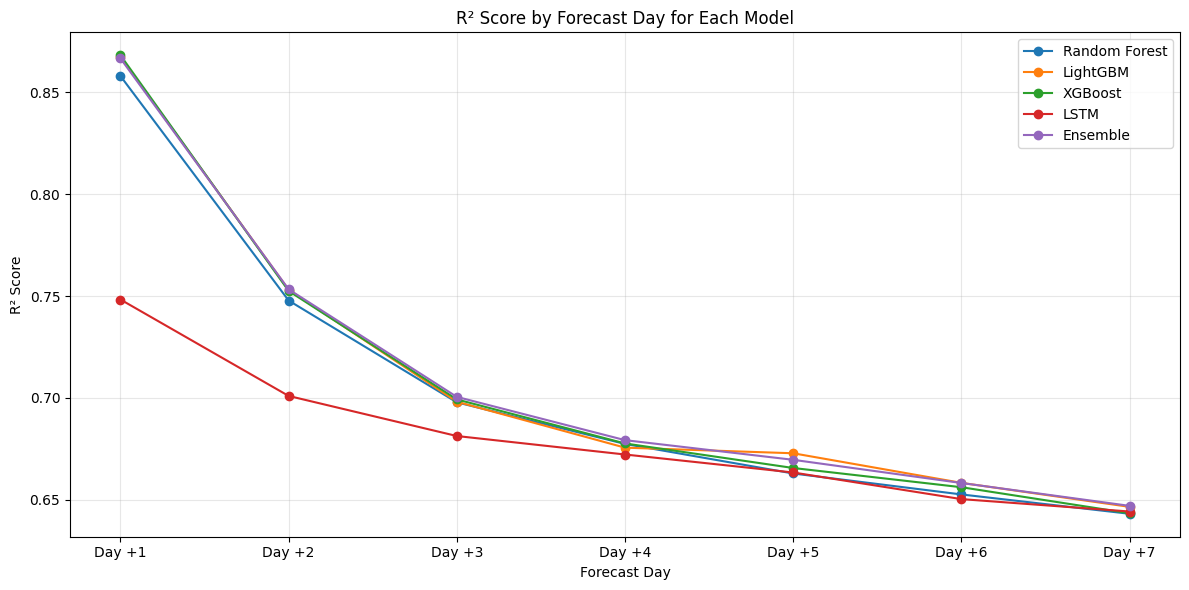

In [60]:
import matplotlib.pyplot as plt
import numpy as np

days = [f"Day +{i+1}" for i in range(H)]
model_names = list(models.keys())

# Prepare per-day MAE, MAPE, and R2 for each model
mae_by_model = {name: [] for name in model_names}
mape_by_model = {name: [] for name in model_names}
r2_by_model = {name: [] for name in model_names}

for name, model in models.items():
    if name == "Ensemble":
        y_pred = model(X_test_fs)
        y_true = Y_test.values
    elif name == "LSTM":
        y_pred = lstm_Y_pred_inv
        y_true = lstm_Y_test_inv
    else:
        y_pred = model.predict(X_test_fs)
        y_true = Y_test.values
    for h in range(H):
        mae = mean_absolute_error(y_true[:, h], y_pred[:, h])
        mape = np.mean(np.abs((y_true[:, h] - y_pred[:, h]) / (y_true[:, h] + 1e-8))) * 100
        r2 = r2_score(y_true[:, h], y_pred[:, h])
        mae_by_model[name].append(mae)
        mape_by_model[name].append(mape)
        r2_by_model[name].append(r2)

# Plot MAE by day for each model (line graph)
plt.figure(figsize=(10, 6))
for name in model_names:
    plt.plot(days, mae_by_model[name], marker='o', label=name)
plt.title('MAE by Forecast Day for Each Model')
plt.xlabel('Forecast Day')
plt.ylabel('MAE')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot MAPE by day for each model (line graph)
plt.figure(figsize=(10, 6))
for name in model_names:
    plt.plot(days, mape_by_model[name], marker='o', label=name)
plt.title('MAPE (%) by Forecast Day for Each Model')
plt.xlabel('Forecast Day')
plt.ylabel('MAPE (%)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot R2 by day for each model (line graph)
plt.figure(figsize=(12, 6))
for name in model_names:
    plt.plot(days, r2_by_model[name], marker='o', label=name)
plt.title('R² Score by Forecast Day for Each Model')
plt.xlabel('Forecast Day')
plt.ylabel('R² Score')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()